In [1]:
# -*- coding: utf-8 -*-
"""
SAM for 3D Instance Segmentation 

Created by Florent Poux, (c) 2023 Licence MIT
To reuse in your project, please cite the most appropriate article accessible on my Google Scholar page

Have fun with this script!
"""

'\nSAM for 3D Instance Segmentation \n\nCreated by Florent Poux, (c) 2023 Licence MIT\nTo reuse in your project, please cite the most appropriate article accessible on my Google Scholar page\n\nHave fun with this script!\n'

In [1]:
#%% 1. Loading Libraries
import os
import numpy as np
import time

import torch
import cv2
import matplotlib.pyplot as plt
import laspy

from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator



In [4]:
#%% 2. Paths
INPUT_FOLDER = "../DATA/"
DATA_NAME = "NAAVIS_EXTERIOR"

PCD_PATH = INPUT_FOLDER + DATA_NAME + ".las"

DATA_PATH = INPUT_FOLDER + DATA_NAME + "/"
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

IMAGE_PATH = DATA_PATH + DATA_NAME + ".jpg"

RESULT_PATH = DATA_PATH + DATA_NAME + "_result_"



In [5]:
#%% 3. SAM Variable checks

CHECKPOINT_PATH ="../MODELS/sam_vit_h_4b8939.pth"  
MODEL_TYPE = "vit_h"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
#%% 4. Parameters settings

resolution = 600
center_coordinates = [16.974,14.168,4.351]
transparency = 0.8



In [7]:
#%% 5. Loading Point Clouds with Laspy

las = laspy.read(PCD_PATH)
coords = np.vstack((las.x, las.y, las.z)).transpose()
r = (las.red/65535*255).astype(int)
g = (las.green/65535*255).astype(int)
b = (las.blue/65535*255).astype(int)
colors = np.vstack((r, g, b)).transpose()


In [9]:
#%% 6. Generate Spherical Image

def generate_spherical_image(center_coordinates, coords, colors, resolution_y=500):
    # Translate the point cloud by the negation of the center coordinates
    translated_points = coords - center_coordinates

    # Convert 3D point cloud to spherical coordinates
    theta = np.arctan2(translated_points[:, 1], translated_points[:, 0])
    phi = np.arccos(translated_points[:, 2] / np.linalg.norm(translated_points, axis=1))

    # Map spherical coordinates to pixel coordinates
    x = (theta + np.pi) / (2 * np.pi) * (2 * resolution_y)
    y = phi / np.pi * resolution_y

    # Create the spherical image with RGB channels
    resolution_x = 2 * resolution_y
    image = np.zeros((resolution_y, resolution_x, 3), dtype=np.uint8)

    # Create the mapping between point cloud and image coordinates
    mapping = np.full((resolution_y, resolution_x), -1, dtype=int)
    mapping_multiple = np.full((resolution_y, resolution_x), -1, dtype=object)

    # Assign points to the image pixels
    for i in range(len(translated_points)):
        ix = np.clip(int(x[i]), 0, resolution_x - 1)
        iy = np.clip(int(y[i]), 0, resolution_y - 1)
        if mapping[iy, ix] == -1 or np.linalg.norm(translated_points[i]) < np.linalg.norm(translated_points[mapping[iy, ix]]):
            mapping[iy, ix] = i
            image[iy, ix] = colors[i]
        if mapping_multiple[iy, ix] == -1:
            mapping_multiple[iy, ix] = []
        mapping_multiple[iy, ix].append(i)

    return image, mapping, mapping_multiple

t0 = time.time()
spherical_image, mapping, mapping_multiple = generate_spherical_image(center_coordinates, coords, colors, resolution)

t1 = time.time()

print(f"Generation of a spherical image in {t1-t0} seconds")


Generation of a spherical image in 107.88982272148132 seconds


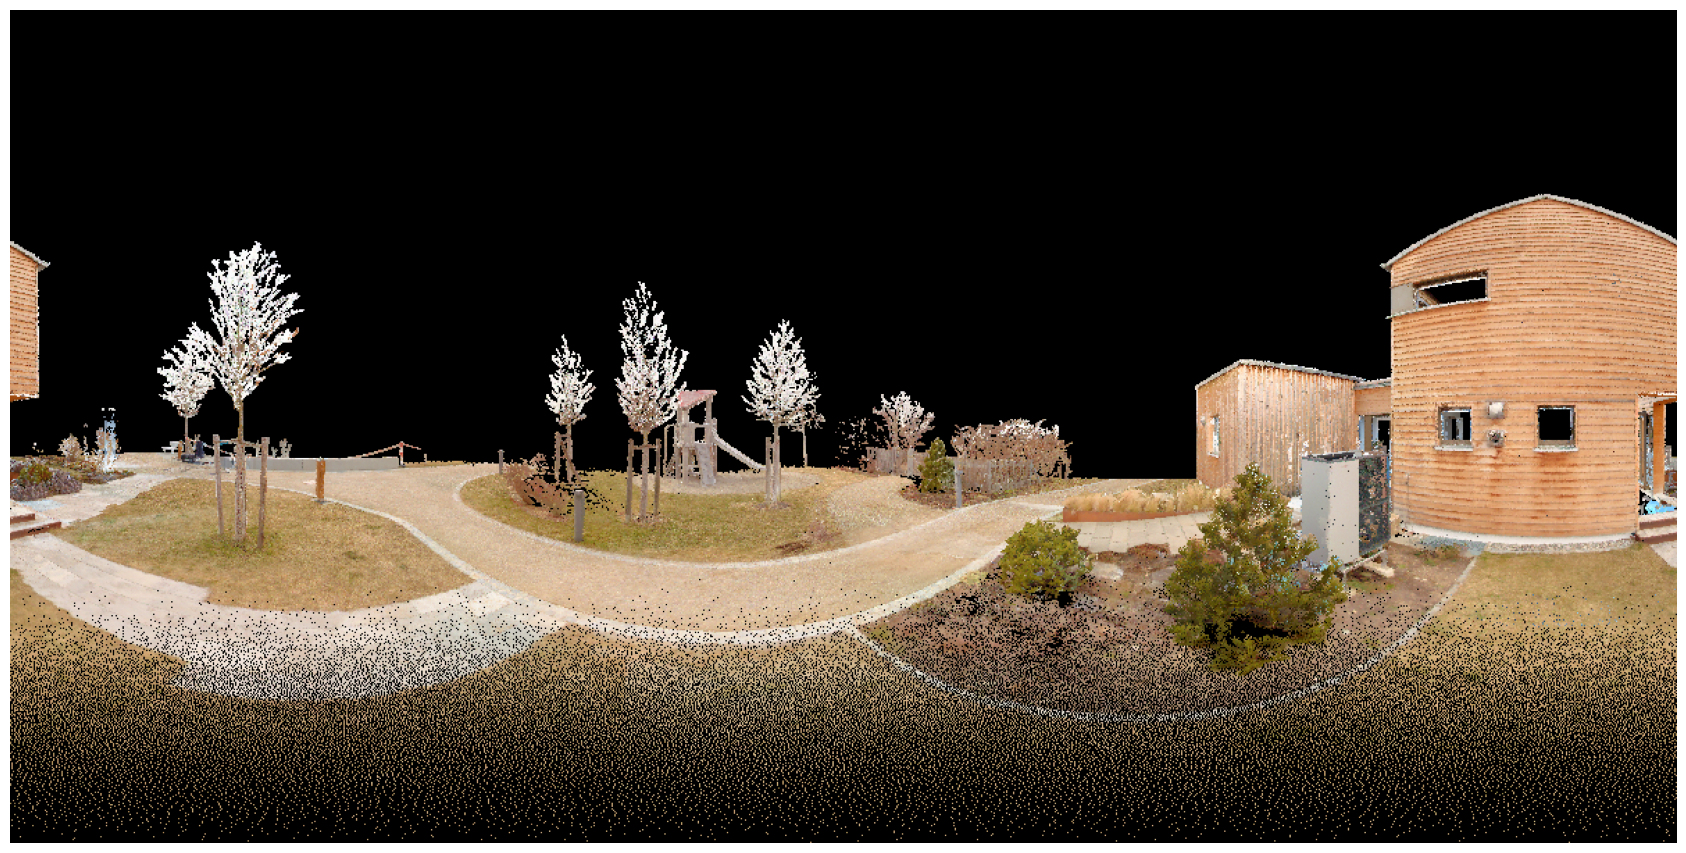

In [20]:
#Plotting and exporting the RGB Panorama
fig = plt.figure(figsize=(resolution * 2 / 72, resolution / 72))  # Ajustar tamaño de la figura
fig.add_axes([0,0,1,1])

plt.imshow(spherical_image)
plt.axis('off')
plt.savefig(IMAGE_PATH, dpi=72)  # Usar dpi=72 para asegurar la resolución correcta


In [21]:
spherical_image.shape

(600, 1200, 3)

In [22]:
#%% 7. Unsupervised Segmentation with SAM

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

t0 = time.time()
result = mask_generator.generate(image_rgb)
t1 = time.time()

print(f"Semantic Segmentation with SAM in {t1-t0} seconds")



Semantic Segmentation with SAM in 49.37144422531128 seconds


In [23]:
result

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 305664,
  'bbox': [0, 2, 1199, 333],
  'predicted_iou': 1.0803215503692627,
  'point_coords': [[206.25, 196.875]],
  'stability_score': 0.9819331169128418,
  'crop_box': [0, 0, 1200, 600]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 146803,
  'bbox': [0, 399, 119

(600, 1200, 3)

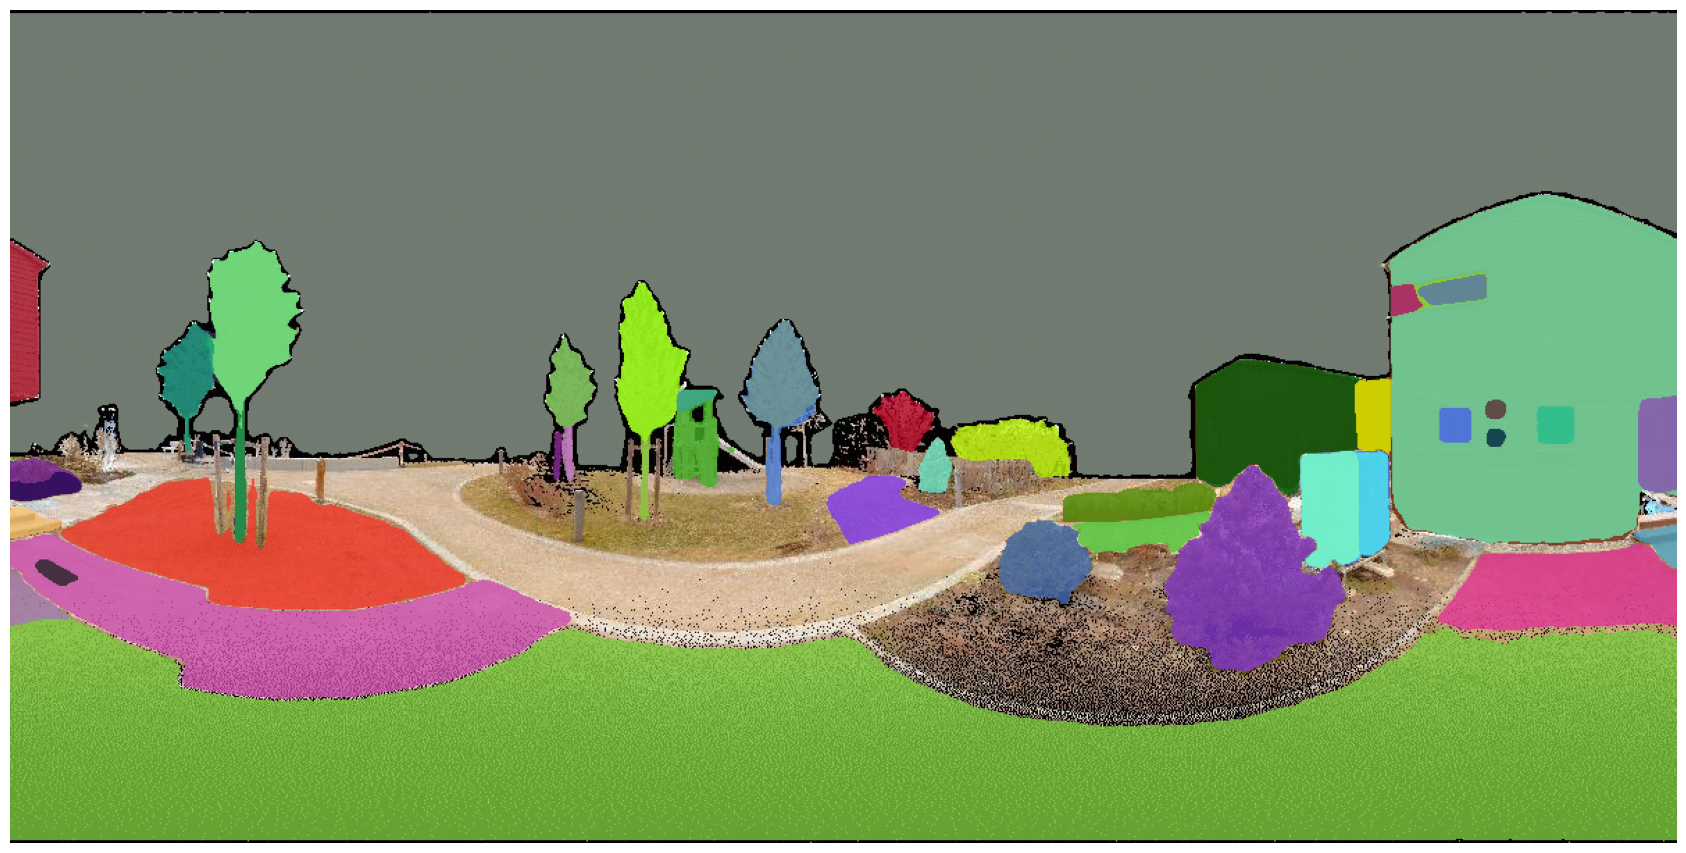

In [24]:
#%% 8. Masking, Plotting and Exporting the 360 panorama
def sam_masks(anns):

    if len(anns) == 0:
        return

    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    c_mask = []

    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * transparency)))
        c_mask.append(img)
        
    return c_mask

fig = plt.figure(figsize=(np.shape(image_rgb)[1]/72, np.shape(image_rgb)[0]/72))
fig.add_axes([0,0,1,1])

plt.imshow(image_rgb)
color_mask = sam_masks(result)
plt.axis('off')
plt.savefig(RESULT_PATH+"panorama.jpg", dpi=72)  # Usar dpi=72 para asegurar la resolución correcta


# %%
image_rgb.shape



In [25]:
image_rgb.shape

(600, 1200, 3)

In [26]:
def export_point_cloud(cloud_path, modified_point_cloud):
        # 1. Create a new header
    header = laspy.LasHeader(point_format=3, version="1.2")
    header.add_extra_dim(laspy.ExtraBytesParams(name="random", type=np.int32))

    # 2. Create a Las
    las_o = laspy.LasData(header)

    las_o.x = modified_point_cloud[:, 0]
    las_o.y = modified_point_cloud[:, 1]
    las_o.z = modified_point_cloud[:, 2]
    las_o.red = modified_point_cloud[:, 3]
    las_o.green = modified_point_cloud[:, 4]
    las_o.blue = modified_point_cloud[:, 5]
    las_o.write(cloud_path)

    print("Export successful at: ", cloud_path)
    return

In [27]:
#%% 9.1. Back Projection Best Point


image_path = RESULT_PATH + "panorama.jpg"

def color_point_cloud(image_path, point_cloud, mapping):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    modified_point_cloud = np.zeros((point_cloud.shape[0], point_cloud.shape[1] + 3), dtype=np.float32)
    modified_point_cloud[:, :3] = point_cloud
    for iy in range(h):
        for ix in range(w):
            point_index = mapping[iy, ix]
            if point_index != -1:
                color = image[iy, ix]
                modified_point_cloud[point_index, 3:] = color
    
    return modified_point_cloud

modified_point_cloud = color_point_cloud(image_path, coords, mapping)
export_point_cloud(RESULT_PATH + "pcd_01_single.las", modified_point_cloud)




Export successful at:  ../DATA/NAAVIS_EXTERIOR/NAAVIS_EXTERIOR_result_pcd_01_single.las


In [28]:
#%% 9.2. Back Projection All Points

image_path=RESULT_PATH+"panorama.jpg"

def color_point_cloud(image_path, point_cloud, mapping, mapping_multiple):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    modified_point_cloud = np.zeros((point_cloud.shape[0], point_cloud.shape[1] + 3), dtype=np.float32)
    modified_point_cloud[:, :3] = point_cloud
    for iy in range(h):
        for ix in range(w):
            point_index = mapping_multiple[iy, ix]
            if point_index != -1:
                color = image[iy, ix]
                modified_point_cloud[point_index, 3:] = color
    return modified_point_cloud

modified_point_cloud = color_point_cloud(image_path, coords, mapping,mapping_multiple)
export_point_cloud(RESULT_PATH + "pcd_02_full.las", modified_point_cloud)



Export successful at:  ../DATA/NAAVIS_EXTERIOR/NAAVIS_EXTERIOR_result_pcd_02_full.las


In [29]:
#%% 9.3. Back Projection Filtered Points

image_path = RESULT_PATH + "panorama.jpg"

def color_point_cloud(image_path, point_cloud, mapping, mapping_multiple, center, threshold=0.01):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    translated_points = point_cloud - center
    modified_point_cloud = np.zeros((point_cloud.shape[0], point_cloud.shape[1] + 3), dtype=np.float32)
    modified_point_cloud[:, :3] = point_cloud
    for iy in range(h):
        for ix in range(w):
            point_index = mapping_multiple[iy, ix]
            if point_index != -1 and type(point_index) == int:
                color = image[iy, ix]
                modified_point_cloud[point_index, 3:] = color
            elif type(point_index) != int:
                color = image[iy, ix]
                for idx in point_index:
                    if np.linalg.norm(translated_points[idx]) > np.linalg.norm(translated_points[mapping[iy, ix]])*(1 + threshold):
                        point_index.remove(idx)
                modified_point_cloud[point_index, 3:] = color
    return modified_point_cloud

modified_point_cloud = color_point_cloud(image_path, coords, mapping, mapping_multiple, center=center_coordinates)
export_point_cloud(RESULT_PATH + "pcd_03_filtered.las", modified_point_cloud)

Export successful at:  ../DATA/NAAVIS_EXTERIOR/NAAVIS_EXTERIOR_result_pcd_03_filtered.las
